In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [3]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'fvec_trainingX')

tfidf_wvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_wvec_trainingX')
tfidf_fvec_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_fvec_trainingX')
tfidf_lsi_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'tfidf_lsi_trainingX')

word2idx_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'trainingY')

CPU times: user 9.97 s, sys: 2.36 s, total: 12.3 s
Wall time: 12.3 s


In [4]:
%%time
ind2word = {j:i for i, j in _word2idx.iteritems()}
ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = trainingY.shape[0]

# ---------------------------------
training_X = word2idx_trainingX.head(num_samples)
training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])

training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_tfidf_WV = tfidf_wvec_trainingX.head(num_samples)
training_tfidf_FS = tfidf_fvec_trainingX.head(num_samples)
training_tfidf_LSI = tfidf_lsi_trainingX.head(num_samples)
# ---------------------------------


# ---------------------------------
training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

indices = sorted(training_Y.index[training_Y.index.str.contains('^201[0-9]')])
# np.random.shuffle(indices)
indices = pd.Index(indices)
# ---------------------------------


# ---------------------------------
training_X = training_X.ix[indices]
training_Y = training_Y.ix[indices]

training_WV = training_WV.ix[indices]
training_FS = training_FS.ix[indices]

training_tfidf_WV = training_tfidf_WV.ix[indices]
training_tfidf_FS = training_tfidf_FS.ix[indices]
training_tfidf_LSI = training_tfidf_LSI.ix[indices]
# ---------------------------------

CPU times: user 12.1 s, sys: 84 ms, total: 12.2 s
Wall time: 12.1 s


In [5]:
%%time
wv_sc = StandardScaler()
fs_sc = StandardScaler()

tfidf_wv_sc = StandardScaler()
tfidf_fs_sc = StandardScaler()
tfidf_lsi_sc = StandardScaler()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [6]:
%%time

from keras.preprocessing import sequence
maxlen = 500


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e


def build_input_output_data(X, WV, FS, TWV, TFS, TLSI, Y, maxlen):
    x = sequence.pad_sequences(X, maxlen=maxlen)
    y = np.vstack(Y.map(lambda x: build_target(x, len(topics))))

    wv = np.vstack(WV)
    fs = np.vstack(FS)

    twv = np.vstack(TWV)
    tfs = np.vstack(TFS)
    tlsi = np.vstack(TLSI)

    return x, wv, fs, twv, tfs, tlsi, y


# ---------------------------------
train_ix = training_Y.index.str.contains('^201[0-4]')
val_ix = training_Y.index.str.contains('^2014[b]')
# ---------------------------------


# ---------------------------------
x_train, wv_train, fs_train, tfidf_wv_train, tfidf_fs_train, tfidf_lsi_train, y_train = build_input_output_data(
    training_X.ix[train_ix],

    training_WV.ix[train_ix],
    training_FS.ix[train_ix],

    training_tfidf_WV.ix[train_ix],
    training_tfidf_FS.ix[train_ix],
    training_tfidf_LSI.ix[train_ix],

    training_Y.ix[train_ix],
    maxlen=maxlen
)
# ---------------------------------


# ---------------------------------
x_val, wv_val, fs_val, tfidf_wv_val, tfidf_fs_val, tfidf_lsi_val, y_val = build_input_output_data(
    training_X.ix[val_ix],

    training_WV.ix[val_ix],
    training_FS.ix[val_ix],

    training_tfidf_WV.ix[val_ix],
    training_tfidf_FS.ix[val_ix],
    training_tfidf_LSI.ix[val_ix],

    training_Y.ix[val_ix],
    maxlen=maxlen
)
# ---------------------------------


# ---------------------------------
wv_train = wv_sc.fit_transform(wv_train)
fs_train = fs_sc.fit_transform(fs_train)

tfidf_wv_train = tfidf_wv_sc.fit_transform(tfidf_wv_train)
tfidf_fs_train = tfidf_fs_sc.fit_transform(tfidf_fs_train)
tfidf_lsi_train = tfidf_lsi_sc.fit_transform(tfidf_lsi_train)
# ---------------------------------


# ---------------------------------
wv_val = wv_sc.transform(wv_val)
fs_val = fs_sc.transform(fs_val)

tfidf_wv_val = tfidf_wv_sc.transform(tfidf_wv_val)
tfidf_fs_val = tfidf_fs_sc.transform(tfidf_fs_val)
tfidf_lsi_val = tfidf_lsi_sc.transform(tfidf_lsi_val)
# ---------------------------------

CPU times: user 3.72 s, sys: 268 ms, total: 3.99 s
Wall time: 3.97 s


In [7]:
training_Y.shape, training_Y.ix[training_Y.index.str.contains('^2014[b]')].shape

((94731,), (9424,))

In [8]:
v = training_tfidf_LSI.ix[train_ix].map(len)
v[v != 300]

Series([], Name: bodyText, dtype: int64)

In [11]:
import tensorflow as K
import keras.backend as KB


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    c2 = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    c3 = KB.sum(KB.round(KB.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [39]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten
from keras.models import Model
import itertools as it


def build_deep_input_stack(input_node):
    x = Dense(128, activation='relu')(input_node)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    return x


def entangle_inputs(input_nodes=[]):
    assert(len(input_nodes) > 1)
    
    entangled_inputs = []

    for n1, n2 in it.combinations(input_nodes, 2):
        entangled_inputs.append(
            keras.layers.dot([n1, n2], 1)
        )
    
    return entangled_inputs


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

tfidf_wv_input = Input(shape=(300,), name='tfidf_wv_input')
tfidf_fs_input = Input(shape=(300,), name='tfidf_fs_input')
tfidf_lsi_input = Input(shape=(300,), name='tfidf_lsi_input')


wv_x = build_deep_input_stack(wv_input)
fs_x = build_deep_input_stack(fs_input)
tfidf_wv_x = build_deep_input_stack(tfidf_wv_input)
tfidf_fs_x = build_deep_input_stack(tfidf_fs_input)
tfidf_lsi_x = build_deep_input_stack(tfidf_wv_input)

stacked_inputs_x = [wv_x, fs_x, tfidf_wv_x, tfidf_fs_x, tfidf_lsi_x]
# entangled_inputs_x = entangle_inputs(stacked_inputs_x)

x = keras.layers.concatenate(stacked_inputs_x)  # + entangled_inputs_x)

# We stack a deep densely-connected network on top
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(
    inputs=[
        wv_input,
        fs_input,
        tfidf_wv_input,
        tfidf_fs_input,
        tfidf_lsi_input,
    ],
    outputs=[main_output]
)

In [40]:
model.compile(
    optimizer='adam',
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
wv_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
fs_input (InputLayer)            (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_wv_input (InputLayer)      (None, 300)           0                                            
____________________________________________________________________________________________________
tfidf_fs_input (InputLayer)      (None, 300)           0                                            
___________________________________________________________________________________________

In [41]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

In [42]:
def build_training_inputs(wv, fs, tfidf_wv, tfidf_fs, tfidf_lsi):
    training_inputs = {
        'wv_input': wv,
        'fs_input': fs,
        'tfidf_wv_input': tfidf_wv,
        'tfidf_fs_input': tfidf_fs,
        'tfidf_lsi_input': tfidf_lsi,
    }
    
    return training_inputs
    

training_inputs = build_training_inputs(
    wv_train,
    fs_train,
    tfidf_wv_train,
    tfidf_fs_train,
    tfidf_lsi_train,
)

training_outputs = {
    'main_output': y_train,
}

validation_data=(
    build_training_inputs(
        wv_val,
        fs_val,
        tfidf_wv_val,
        tfidf_fs_val,
        tfidf_lsi_val,
    ),
    {
        'main_output': y_val,
    }
)

In [91]:
%%time
# And trained it via:
batch_size = 500
epochs = 100

hist = model.fit(
    training_inputs,
    training_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    validation_data=validation_data,
)

Train on 94731 samples, validate on 9424 samples
Epoch 1/100
94731/94731 [==============================] - 2s - loss: 1.8748 - acc: 0.6773 - f1_micro: 0.6541 - val_loss: 1.4968 - val_acc: 0.7454 - val_f1_micro: 0.6542
Epoch 2/100
94731/94731 [==============================] - 2s - loss: 1.8718 - acc: 0.6780 - f1_micro: 0.6544 - val_loss: 1.4974 - val_acc: 0.7366 - val_f1_micro: 0.6545
Epoch 3/100
94731/94731 [==============================] - 1s - loss: 1.8809 - acc: 0.6768 - f1_micro: 0.6547 - val_loss: 1.5022 - val_acc: 0.7398 - val_f1_micro: 0.6548
Epoch 4/100
94731/94731 [==============================] - 1s - loss: 1.8741 - acc: 0.6792 - f1_micro: 0.6550 - val_loss: 1.5025 - val_acc: 0.7423 - val_f1_micro: 0.6551
Epoch 5/100
94731/94731 [==============================] - 1s - loss: 1.8734 - acc: 0.6759 - f1_micro: 0.6552 - val_loss: 1.4876 - val_acc: 0.7466 - val_f1_micro: 0.6554
Epoch 6/100
94731/94731 [==============================] - 1s - loss: 1.8768 - acc: 0.6768 - f1_micro

94731/94731 [==============================] - 1s - loss: 1.8308 - acc: 0.6842 - f1_micro: 0.6668 - val_loss: 1.4526 - val_acc: 0.7412 - val_f1_micro: 0.6670
Epoch 49/100
94731/94731 [==============================] - 1s - loss: 1.8403 - acc: 0.6817 - f1_micro: 0.6671 - val_loss: 1.4619 - val_acc: 0.7440 - val_f1_micro: 0.6672
Epoch 50/100
94731/94731 [==============================] - 2s - loss: 1.8411 - acc: 0.6822 - f1_micro: 0.6673 - val_loss: 1.4598 - val_acc: 0.7421 - val_f1_micro: 0.6674
Epoch 51/100
94731/94731 [==============================] - 2s - loss: 1.8315 - acc: 0.6821 - f1_micro: 0.6676 - val_loss: 1.4610 - val_acc: 0.7388 - val_f1_micro: 0.6677
Epoch 52/100
94731/94731 [==============================] - 1s - loss: 1.8366 - acc: 0.6816 - f1_micro: 0.6678 - val_loss: 1.4579 - val_acc: 0.7488 - val_f1_micro: 0.6679
Epoch 53/100
94731/94731 [==============================] - 1s - loss: 1.8399 - acc: 0.6819 - f1_micro: 0.6680 - val_loss: 1.4588 - val_acc: 0.7542 - val_f1_m

94731/94731 [==============================] - 1s - loss: 1.8054 - acc: 0.6866 - f1_micro: 0.6767 - val_loss: 1.4297 - val_acc: 0.7435 - val_f1_micro: 0.6768
Epoch 96/100
94731/94731 [==============================] - 1s - loss: 1.8147 - acc: 0.6857 - f1_micro: 0.6769 - val_loss: 1.4288 - val_acc: 0.7500 - val_f1_micro: 0.6770
Epoch 97/100
94731/94731 [==============================] - 1s - loss: 1.8103 - acc: 0.6856 - f1_micro: 0.6771 - val_loss: 1.4238 - val_acc: 0.7517 - val_f1_micro: 0.6772
Epoch 98/100
94731/94731 [==============================] - 1s - loss: 1.8116 - acc: 0.6840 - f1_micro: 0.6773 - val_loss: 1.4278 - val_acc: 0.7525 - val_f1_micro: 0.6774
Epoch 99/100
94731/94731 [==============================] - 2s - loss: 1.8133 - acc: 0.6868 - f1_micro: 0.6774 - val_loss: 1.4312 - val_acc: 0.7605 - val_f1_micro: 0.6775
Epoch 100/100
94731/94731 [==============================] - 1s - loss: 1.8059 - acc: 0.6847 - f1_micro: 0.6776 - val_loss: 1.4254 - val_acc: 0.7536 - val_f1_

In [19]:
hist.history

{'acc': [0.0],
 'f1_micro': [0.022502759915887773],
 'loss': [1.8220217678544056e-07],
 'val_acc': [0.0],
 'val_f1_micro': [0.022132802858999306],
 'val_loss': [1.8207752097591942e-07]}

In [107]:
%%time
log_history_file = 'lstm-word2vec-fasttext-lsi.epoch.csv'
model_name = 'models/tfidf-wv-fs-lsi-2010-2014-data_cat-crossentropy-2014-b-val-sc_tfidf_wv_fs_lsi.model'
batch_size = 1200
epochs = 5
total_epochs = 100

for i in xrange(0, total_epochs // epochs):
    hist = model.fit(
        training_inputs,
        training_outputs,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        validation_data=validation_data,
    )

    model.save(model_name.format(i))
    print
    print('Done with epoch: {}'.format((i + 1) * epochs))
    with open(log_history_file, 'a') as fl:
        fl.write(model_name + '\n')
        fl.write('Epoch {}\n'.format((i + 1) * epochs))
        fl.write('{}\n'.format(datetime.now()))
        fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
        fl.write('\n\n')
    print

Train on 94731 samples, validate on 9424 samples
Epoch 1/5
94731/94731 [==============================] - 0s - loss: 1.9223 - acc: 0.6675 - f1_micro: 0.6154 - val_loss: 1.5412 - val_acc: 0.7377 - val_f1_micro: 0.6154
Epoch 2/5
94731/94731 [==============================] - 0s - loss: 1.9187 - acc: 0.6692 - f1_micro: 0.6154 - val_loss: 1.5448 - val_acc: 0.7409 - val_f1_micro: 0.6154
Epoch 3/5
94731/94731 [==============================] - 0s - loss: 1.9205 - acc: 0.6683 - f1_micro: 0.6155 - val_loss: 1.5374 - val_acc: 0.7429 - val_f1_micro: 0.6155
Epoch 4/5
94731/94731 [==============================] - 0s - loss: 1.9227 - acc: 0.6703 - f1_micro: 0.6155 - val_loss: 1.5447 - val_acc: 0.7329 - val_f1_micro: 0.6155
Epoch 5/5
94731/94731 [==============================] - 0s - loss: 1.9203 - acc: 0.6685 - f1_micro: 0.6155 - val_loss: 1.5355 - val_acc: 0.7364 - val_f1_micro: 0.6155

Done with epoch: 5

Train on 94731 samples, validate on 9424 samples
Epoch 1/5
94731/94731 [==================

94731/94731 [==============================] - 0s - loss: 1.9168 - acc: 0.6684 - f1_micro: 0.6167 - val_loss: 1.5317 - val_acc: 0.7375 - val_f1_micro: 0.6167
Epoch 2/5
94731/94731 [==============================] - 0s - loss: 1.9138 - acc: 0.6709 - f1_micro: 0.6168 - val_loss: 1.5307 - val_acc: 0.7391 - val_f1_micro: 0.6168
Epoch 3/5
94731/94731 [==============================] - 0s - loss: 1.9131 - acc: 0.6717 - f1_micro: 0.6168 - val_loss: 1.5264 - val_acc: 0.7419 - val_f1_micro: 0.6168
Epoch 4/5
94731/94731 [==============================] - 0s - loss: 1.9199 - acc: 0.6672 - f1_micro: 0.6168 - val_loss: 1.5316 - val_acc: 0.7385 - val_f1_micro: 0.6168
Epoch 5/5
94731/94731 [==============================] - 0s - loss: 1.9186 - acc: 0.6696 - f1_micro: 0.6168 - val_loss: 1.5284 - val_acc: 0.7426 - val_f1_micro: 0.6169

Done with epoch: 50

Train on 94731 samples, validate on 9424 samples
Epoch 1/5
94731/94731 [==============================] - 0s - loss: 1.9110 - acc: 0.6696 - f1_micro

94731/94731 [==============================] - 0s - loss: 1.9131 - acc: 0.6711 - f1_micro: 0.6180 - val_loss: 1.5285 - val_acc: 0.7411 - val_f1_micro: 0.6180
Epoch 2/5
94731/94731 [==============================] - 0s - loss: 1.9154 - acc: 0.6713 - f1_micro: 0.6180 - val_loss: 1.5232 - val_acc: 0.7392 - val_f1_micro: 0.6180
Epoch 3/5
94731/94731 [==============================] - 0s - loss: 1.9101 - acc: 0.6670 - f1_micro: 0.6181 - val_loss: 1.5253 - val_acc: 0.7344 - val_f1_micro: 0.6181
Epoch 4/5
94731/94731 [==============================] - 0s - loss: 1.9152 - acc: 0.6685 - f1_micro: 0.6181 - val_loss: 1.5293 - val_acc: 0.7348 - val_f1_micro: 0.6181
Epoch 5/5
94731/94731 [==============================] - 0s - loss: 1.9085 - acc: 0.6697 - f1_micro: 0.6181 - val_loss: 1.5267 - val_acc: 0.7393 - val_f1_micro: 0.6181

Done with epoch: 95

Train on 94731 samples, validate on 9424 samples
Epoch 1/5
94731/94731 [==============================] - 0s - loss: 1.9121 - acc: 0.6704 - f1_micro

In [102]:
%%time
total_epochs = 100
for j in xrange(i, i + (total_epochs // epochs)):
    hist = model.fit(
        training_inputs,
        training_outputs,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        validation_data=validation_data,
    )

    model.save(model_name.format(i))
    print
    print('Done with epoch: {}'.format((j + 1) * epochs))
    with open(log_history_file, 'a') as fl:
        fl.write(model_name + '\n')
        fl.write('Epoch {}\n'.format((j + 1) * epochs))
        fl.write('{}\n'.format(datetime.now()))
        fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
        fl.write('\n\n')
    print

Train on 94731 samples, validate on 9424 samples
Epoch 1/5
94731/94731 [==============================] - 51s - loss: 1.6427 - main_output_loss: 1.3490 - aux_output_loss: 1.4686 - main_output_acc: 0.7712 - main_output_f1_micro: 0.6905 - aux_output_acc: 0.7839 - aux_output_f1_micro: 0.1085 - val_loss: 1.4372 - val_main_output_loss: 1.1302 - val_aux_output_loss: 1.5348 - val_main_output_acc: 0.7941 - val_main_output_f1_micro: 0.6913 - val_aux_output_acc: 0.7884 - val_aux_output_f1_micro: 0.1086
Epoch 2/5
94731/94731 [==============================] - 51s - loss: 1.5833 - main_output_loss: 1.2980 - aux_output_loss: 1.4265 - main_output_acc: 0.7738 - main_output_f1_micro: 0.6921 - aux_output_acc: 0.7855 - aux_output_f1_micro: 0.1088 - val_loss: 1.4210 - val_main_output_loss: 1.1179 - val_aux_output_loss: 1.5153 - val_main_output_acc: 0.7967 - val_main_output_f1_micro: 0.6930 - val_aux_output_acc: 0.7949 - val_aux_output_f1_micro: 0.1090
Epoch 3/5
94731/94731 [==============================

In [103]:
# model = keras.models.load_model(
#     'models/lstm-word2vec-fasttext_2010-2014-data_categorical-crossentropy-2014-b-val-standard_scaled_wv_fs.model',
#     custom_objects={'f1_micro': f1_micro}
# )

In [104]:
i = j

In [92]:
g = model.predict(
    build_training_inputs(
        wv_train[:100],
        fs_train[:100],
        tfidf_wv_train[:100],
        tfidf_fs_train[:100],
        tfidf_lsi_train[:100],
    )
)

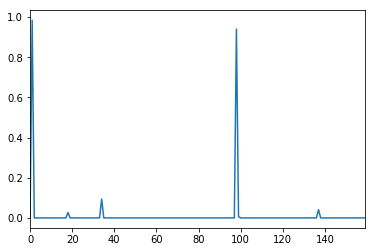

In [93]:
%matplotlib inline
ix = 29
pd.Series(g[ix]).plot()

In [94]:
thresh = 0.5
np.where(y_train[ix] == 1), np.where(g[ix] > thresh)

((array([ 1, 98]),), (array([ 1, 98]),))

In [50]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.corpora import Dictionary

In [51]:
dictionary = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.dictionary')
tfidf = TfidfModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.tfidf')
lsi = LsiModel.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.lsi')

In [52]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [53]:
fsmodel = fasttext.load_model('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model.bin')

In [54]:
def transform_tfidf_word2vec(tokens, stopwords=[]):
#     global wvmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([wvmodel[dictionary.id2token[id]] * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return wv_feature_vec


def transform_tfidf_fasttext(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: tfidf[dictionary.doc2bow(x)]
    ).map(
        lambda x: np.array([np.array(fsmodel[dictionary.id2token[id]]) * w for id, w in x]).mean(axis=0) if len(x) > 0 else np.nan
    )

    return fs_feature_vec


def build_lsi_vector(l):
    v = np.zeros(lsi.num_topics)
    
    for ix, vv in lsi[tfidf[dictionary.doc2bow(l)]]:
        v[ix] = vv
        
    return v


def transform_tfidf_lsi(tokens, stopwords=[]):
#     global fsmodel
#     global tfidf
    # This requires wvmodel to be present in the namespace.
    lsi_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(
        lambda x: build_lsi_vector(x) if len(x) > 0 else np.nan
    )

    return lsi_feature_vec


def transform_fasttext(tokens, stopwords=[]):
    global fsmodel
    # This requires fsmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(lambda x: np.array([fsmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return fs_feature_vec


def transform_unsupervised_sentiment_neuron(tokens, stopwords=[]):
    # This requires fsmodel to be present in the namespace.
    
    usn_feature_vec = usnmodel.transform(tokens)

    # usn_feature_vec = tokens.map(
    #     lambda x: [w for w in x.split() if (w not in stopwords)]
    # ).map(lambda x: np.array([usnmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return usn_feature_vec


def transform_word2vec(tokens, stopwords=[]):
    global wvmodel
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(lambda x: np.array([wvmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return wv_feature_vec


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


In [55]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [56]:
def word2idx_transform(word, _word2idx):
    return _word2idx.get(word, 0)


In [57]:
def extract_features_for(df, min_batch=2000, stopwords=[], num_proc=7):
    df_tokens = transform_text(df)
    
    batch = min(df_tokens.shape[0] / num_proc, min_batch)

    print('Computing fs features...')
    fvec = parallel_generate_word_vectors(df_tokens, transform_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing wv features...')
    wvec = parallel_generate_word_vectors(df_tokens, transform_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Mapping word indices...')
    word_indices = df_tokens.map(lambda x: [word2idx_transform(i, _word2idx) for i in x.split()])

    print('Computing tfidf fs features...')
    tfidf_fvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf wv features...')
    tfidf_wvec = parallel_generate_word_vectors(df_tokens, transform_tfidf_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing tfidf lsi features...')
    tfidf_lsi = parallel_generate_word_vectors(df_tokens, transform_tfidf_lsi, stopwords=stopwords, batch=batch, num_proc=num_proc)
    
    return word_indices, wvec, fvec, tfidf_wvec, tfidf_fvec, tfidf_lsi

In [58]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [59]:
%%time
test_word_indices,test_wvec, test_fvec, test_tfidf_wvec, test_tfidf_fvec, test_tfidf_lsi = extract_features_for(
    test_df
)

Computing fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Mapping word indices...
Computing tfidf fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing tfidf lsi features...
Current batch in main thread: 6498
Current batch in main thread: 14079
CPU times: user 50.1 s, sys: 6.48 s, total: 56.6 s
Wall time: 2min 5s


In [60]:
assert(np.all(test_wvec[test_wvec.isnull()].index == test_fvec[test_fvec.isnull()].index))
test_null_index = test_wvec[test_wvec.isnull()].index.union(test_fvec[test_fvec.isnull()].index)

In [61]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

In [62]:
%%time
valid_test_index = test_word_indices.index.difference(test_null_index)
x_test = test_word_indices.ix[valid_test_index]  # .map(lambda x: [top_token2ind.get(i, 0) for i in x])

x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

wv_test = np.vstack(test_wvec.ix[valid_test_index])
fs_test = np.vstack(test_fvec.ix[valid_test_index])

tfidf_wv_test = np.vstack(test_tfidf_wvec.ix[valid_test_index])
tfidf_fs_test = np.vstack(test_tfidf_fvec.ix[valid_test_index])
tfidf_lsi_test = np.vstack(test_tfidf_lsi.ix[valid_test_index])

wv_test = wv_sc.transform(wv_test)
fs_test = fs_sc.transform(fs_test)

tfidf_wv_test = tfidf_wv_sc.transform(tfidf_wv_test)
tfidf_fs_test = tfidf_fs_sc.transform(tfidf_fs_test)
tfidf_lsi_test = tfidf_lsi_sc.transform(tfidf_lsi_test)

test_inputs = build_training_inputs(
    wv_test,
    fs_test,
    tfidf_wv_test,
    tfidf_fs_test,
    tfidf_lsi_test,
)

CPU times: user 344 ms, sys: 36 ms, total: 380 ms
Wall time: 383 ms


In [63]:
test_probas = model.predict(test_inputs, batch_size=batch_size)

In [64]:
main_test_probas = test_probas

In [65]:
main_test_probas

array([[  0.00000000e+00,   3.51521989e-09,   3.23756189e-10, ...,
          5.97743299e-10,   1.83255998e-13,   0.00000000e+00],
       [  6.50782562e-29,   1.56475357e-06,   3.82902817e-06, ...,
          1.69156135e-06,   4.58016647e-09,   1.05622823e-27],
       [  0.00000000e+00,   6.99282132e-10,   1.03787148e-08, ...,
          1.18757149e-09,   2.83694548e-16,   0.00000000e+00],
       ..., 
       [  1.39064109e-16,   5.45442244e-03,   3.08843195e-01, ...,
          6.54218226e-08,   1.21962780e-03,   1.13630343e-16],
       [  3.10283707e-22,   1.89735810e-03,   2.62519025e-04, ...,
          4.38363259e-06,   2.97837602e-07,   4.08869687e-22],
       [  3.73695219e-25,   1.48586929e-04,   4.95965534e-04, ...,
          8.57271687e-07,   2.35180209e-09,   7.00528846e-25]], dtype=float32)

In [66]:
skip_index = [int(s.split('_')[1]) - 1 for s in test_null_index]  # Subtract 1 since test index starts at 1 while enumerate starts at 0
skip_index

[2542, 5011, 5829]

In [67]:
main_test_probas.shape, test_df.shape

((7578, 160), (7581, 3))

In [116]:
%%time
# valid_test_feature_vec found below!
thresh = 0.225
test_values = np.zeros([main_test_probas.shape[0], len(topics)])
for ix, pred in enumerate(main_test_probas):
    for v in get_classes(pred, thresh=thresh):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.ix[test_df.index.difference(test_null_index)].index,
    columns=topics
)

null_test_df = pd.DataFrame(
    np.zeros((len(test_null_index), len(topics))),
    index=test_null_index,
    columns=topics
)

test_sub_df = test_sub_df.append(null_test_df)
test_sub_df = test_sub_df.sort_index()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 33.6 ms


In [104]:
# 9627 (0.5), 14297 (0.3)

In [117]:
test_sub_df.sum().sum()

14663.0

In [124]:
test_sub_df.sum().sum()

14432.0

In [73]:
test_sub_df.sum().sum()

13897.0

In [109]:
test_sub_df.sum().sum()

12489.0

In [133]:
test_word_indices.map(len).describe()

count    7581.000000
mean      882.691070
std       621.585386
min         0.000000
25%       552.000000
50%       770.000000
75%      1026.000000
max      8171.000000
Name: bodyText, dtype: float64

In [134]:
test_word_indices.map(len).quantile(0.9)

1382.0

In [130]:
len(test_df.ix['TestData_04490'].bodyText.split())

1223

In [76]:
hist.history['main_output_f1_micro']

KeyError: 'main_output_f1_micro'

In [103]:
print '94731/94731 [==============================] - 1s - loss: 1.8059 - acc: 0.6847 - f1_micro: 0.6776 - val_loss: 1.4254 - val_acc: 0.7536 - val_f1_micro: 0.6777'

94731/94731 [==============================] - 1s - loss: 1.8059 - acc: 0.6847 - f1_micro: 0.6776 - val_loss: 1.4254 - val_acc: 0.7536 - val_f1_micro: 0.6777


In [112]:
sub_filename = 'tfidf_wv_300-fs_300-lsi_300-deep_stack_net-epochs_260-f1_0.6776-data_2010_2014-val_data_2014-thresh_{}-with_sc_wv_fs_lsi.csv'.format(thresh)

In [113]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    sub_filename, 
    index=False
)

In [81]:
test_sub_df.shape

(7581, 160)

In [ ]:
TestData_04490	The World Health Organisation has convened an ...	[]	28-01-2016
TestData_04550	Spraying pesticides will fail to deal with the...	[]	02-02-2016
TestData_05683	Violent protests at Trump rally in California ...	[]	03-06-2016
TestData_05869	Last weekend, we saw the darkest side of human...	[]	17-06-2016
TestData_06148	As dusk falls over Copacabana beach, Ubira San...	[]	16-07-2016
TestData_06291	It is 3pm and yet another patient is brought t...	[]	27-07-2016
TestData_06610	Huddled around their hives, beekeepers around ...	[]	04-09-2016
TestData_06708	A United Nations high-level panel on access to...	[]	14-09-2016
TestData_07263	WHO: Zika virus is no longer a world threat Th...	[]	19-11-2016
TestData_07478	1 World Health Organisation declares a public ...	[]	18-12-2016

In [82]:
ix = 5868
test_sub_df.iloc[ix][test_sub_df.iloc[ix] == 1]

guncrime        1.0
usguncontrol    1.0
Name: TestData_05869, dtype: float64

In [111]:
# %%time
# adjust_index = 0
# # valid_test_feature_vec found below!
# test_values = np.zeros([test_df.shape[0], len(topics)])
# for ix, pred in enumerate(main_test_probas):
#     if ix in skip_index:
#         test_values[ix] = np.nan
#         # Increment adjust index so that we have the correct index for other samples
#         adjust_index += 1
#         continue

#     for v in get_classes(pred, thresh=0.05):
#         test_values[ix + adjust_index][v] = 1

# test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)

# q = test_sub_df.sum(axis=1)
# assert(len(q[q.isnull()].index.difference(test_null_index)) == 0)

# test_sub_df = test_sub_df.fillna(0)

# # for i in test_feature_vec[test_feature_vec.isnull()].index:
# #     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 32.6 ms


In [40]:
test_sub_df.ix[test_null_index].sum(axis=1)

TestData_02543    0.0
TestData_05012    0.0
TestData_05830    0.0
dtype: float64

In [41]:
test_sub_df.sum().sum()

11656.0

In [124]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_64_64_64-cat_cross-epoch_210-batch_size_750-val_main_output_f1_micro_0.5760-main_output_f1_micro_0.5751-main_output_loss_0.9143-data_2010_2013-val_data_2014-thresh_0.05.csv', 
    index=False
)

In [86]:
e = test_sub_df['zikavirus']
e[e==1]

Series([], Name: zikavirus, dtype: float64)

In [87]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')
top_submission.set_index('id').sum().sum()

14328

In [88]:
wrong_index_lstm_sub = pd.read_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv')
wrong_index_lstm_sub.set_index('id').sum().sum()

9280

In [89]:
some_sub = pd.read_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv')
some_sub.set_index('id').sum().sum()

34952

In [90]:
print top_submission.set_index('id')[top_submission.set_index('id').sum(axis=1) == 0].shape

print wrong_index_lstm_sub.set_index('id')[wrong_index_lstm_sub.set_index('id').sum(axis=1) == 0].shape

print some_sub.set_index('id')[some_sub.set_index('id').sum(axis=1) == 0].shape

print test_sub_df[test_sub_df.sum(axis=1) == 0].shape

(2197, 160)
(3957, 160)
(12, 160)
(1503, 160)


In [106]:
top_submission.set_index('id').ix[q[q == 0].index].sum(axis=1)

TestData_00011     0
TestData_00012     0
TestData_00015     0
TestData_00027     3
TestData_00029     0
TestData_00038     1
TestData_00042     5
TestData_00053     4
TestData_00056     1
TestData_00060     1
TestData_00066     0
TestData_00085     0
TestData_00087     1
TestData_00090     0
TestData_00092     0
TestData_00107     3
TestData_00111     0
TestData_00114     0
TestData_00115     1
TestData_00118     0
TestData_00119     0
TestData_00121     0
TestData_00123     0
TestData_00125     0
TestData_00127     0
TestData_00128     1
TestData_00139     1
TestData_00140     1
TestData_00144     0
TestData_00147     2
                  ..
TestData_07445     0
TestData_07456     3
TestData_07461     1
TestData_07462     4
TestData_07465     0
TestData_07468     0
TestData_07471     1
TestData_07475     0
TestData_07486    10
TestData_07495     1
TestData_07509     0
TestData_07514     3
TestData_07515     1
TestData_07523     0
TestData_07533     2
TestData_07534     2
TestData_0754

In [91]:
q = test_sub_df.sum(axis=1)
q[q==0].shape

(1222,)

In [92]:
q.describe()

count    7581.000000
mean        2.160929
std         1.739411
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [157]:
q = trainingY.sum(axis=1)

In [158]:
q.describe()

count    236286.000000
mean          1.392787
std           0.762577
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
dtype: float64

In [82]:
test_df.sample(5)

,bodyText,topics,webPublicationDate
TestData_03241,A special British police unit was put on stand...,[],15-11-2015
TestData_04088,The youngest convict in a fatal gang-rape in N...,[],20-12-2015
TestData_06306,Former New York City mayor Rudy Giuliani has s...,[],28-07-2016
TestData_06083,"John Cantlie, the British journalist who has b...",[],13-07-2016
TestData_05896,Lawyers for the companies that manufactured an...,[],20-06-2016


In [89]:
test_ix = 'TestData_03241'

In [90]:
q = test_sub_df.ix[test_ix]
q[q>0]

london                1.0
metropolitanpolice    1.0
police                1.0
uksecurity            1.0
Name: TestData_03241, dtype: float64

In [91]:
q = top_submission.set_index('id').ix[test_ix]
q[q>0]

ukcrime    1
Name: TestData_04088, dtype: int64

In [92]:
q = some_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
india          1
protest        1
ukcrime        1
Name: TestData_04088, dtype: int64

In [62]:
q = wrong_index_lstm_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
Name: TestData_02924, dtype: int64

In [ ]:
Counter-terrorism policy
 
Foreign policy
 
Defence policy
 
Islamic State
 
Syria
 
news

In [83]:
s = trainingY.sum()
unseen_topics = s[s.isnull()].index

In [85]:
set(topics).intersection(unseen_topics)

{'activism',
 'bastilledaytruckattack',
 'berlinchristmasmarketattack',
 'brusselsattacks',
 'charliehebdoattack',
 'francetrainattack',
 'munichshooting',
 'orlandoterrorattack',
 'parisattacks',
 'peaceandreconciliation',
 'sanbernardinoshooting',
 'tunisiaattack2015',
 'turkeycoupattempt',
 'zikavirus'}

In [170]:
for i in topics:
    print i

activism
afghanistan
aid
algerianhostagecrisis
alqaida
alshabaab
antiwar
arabandmiddleeastprotests
armstrade
australianguncontrol
australiansecurityandcounterterrorism
bastilledaytruckattack
belgium
berlinchristmasmarketattack
bigdata
biometrics
bokoharam
bostonmarathonbombing
britisharmy
brusselsattacks
cameroon
carers
charliehebdoattack
chemicalweapons
clusterbombs
cobra
conflictanddevelopment
controversy
criminaljustice
cybercrime
cyberwar
darknet
dataprotection
debate
defence
deflation
drones
drugs
drugspolicy
drugstrade
earthquakes
ebola
economy
egypt
encryption
energy
espionage
ethics
europeanarrestwarrant
europeancourtofhumanrights
events
extradition
famine
farright
firefighters
forensicscience
france
francetrainattack
freedomofspeech
genevaconventions
germany
guncrime
hacking
hashtags
helicoptercrashes
humanitarianresponse
humanrights
humanrightsact
humantrafficking
immigration
india
indonesia
internallydisplacedpeople
internationalcourtofjustice
internationalcriminaljustice
in

In [263]:
cosine_similarity(wvmodel['zika'], np.vstack(test_wvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.3445929

In [259]:
cosine_similarity(fsmodel['zika'], np.vstack(test_fvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.38107796869050226

In [251]:
test_df.ix[4488 + 1]

bodyText              The World Health Organisation has convened an ...
topics                                                               []
webPublicationDate                                           28-01-2016
Name: TestData_04490, dtype: object

In [257]:
test_df.ix[6727 + 2]

bodyText              The United Nations security council has called...
topics                                                               []
webPublicationDate                                           17-09-2016
Name: TestData_06730, dtype: object

In [253]:
test_df.ix[359]

bodyText              We are deeply concerned that the counter-terro...
topics                                                               []
webPublicationDate                                           02-02-2015
Name: TestData_00360, dtype: object

In [270]:
q = test_sub_df.iloc[4488 + 1]
q[q > 0]

drugstrade    1.0
Name: TestData_04490, dtype: float64